In [5]:
# Import libraries
import os
import sys
import torch
import gc
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [6]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [7]:
# Import modules
from src.data.dataset import ThermalDataset
from src.utils.visualization import plot_class_distribution
from src.data.dataset import save_large_dataset

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Create paths to the preprocessed datasets
cotopaxi_path = os.path.join(project_root, 'data', 'processed', 'cotopaxi_preprocessed.pt')
reventador_path = os.path.join(project_root, 'data', 'processed', 'reventador_preprocessed.pt')

# Load the datasets
print("Loading Cotopaxi dataset...")
cotopaxi_dataset = torch.load(cotopaxi_path)
print("Cotopaxi dataset loaded.")

print("\nLoading Reventador dataset...")
reventador_dataset = torch.load(reventador_path)
print("Reventador dataset loaded.")

Loading Cotopaxi dataset...


C:\Users\Francisco\AppData\Local\Temp\ipykernel_12668\67624139.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cotopaxi_dataset = torch.load(cotopaxi_path)


Cotopaxi dataset loaded.

Loading Reventador dataset...


C:\Users\Francisco\AppData\Local\Temp\ipykernel_12668\67624139.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reventador_dataset = torch.load(reventador_path)


Reventador dataset loaded.


In [22]:
# Check Tensor Sizes Before Merging
print("--- Checking Cotopaxi Dataset Shapes ---")
for key, tensor in cotopaxi_dataset['tensors'].items():
    if isinstance(tensor, dict):
        for name, t in tensor.items():
            print(f"Cotopaxi '{key}'-'{name}': {t.shape}")
    else:
        print(f"Cotopaxi '{key}': {tensor.shape}")
print(f"Cotopaxi 'numeric_labels': {cotopaxi_dataset['labels']['numeric_labels'].shape}")

print("\n--- Checking Reventador Dataset Shapes ---")
for key, tensor in reventador_dataset['tensors'].items():
    if isinstance(tensor, dict):
        for name, t in tensor.items():
            print(f"Reventador '{key}'-'{name}': {t.shape}")
    else:
        print(f"Reventador '{key}': {tensor.shape}")
print(f"Reventador 'numeric_labels': {reventador_dataset['labels']['numeric_labels'].shape}")

--- Checking Cotopaxi Dataset Shapes ---
Cotopaxi 'corrected': torch.Size([240, 320, 7024])
Cotopaxi 'edge': torch.Size([240, 320, 7024])
Cotopaxi 'edge_features': torch.Size([7024, 3])
Cotopaxi 'threshold'-'low': torch.Size([240, 320, 7024])
Cotopaxi 'threshold'-'medium': torch.Size([240, 320, 7024])
Cotopaxi 'threshold'-'high': torch.Size([240, 320, 7024])
Cotopaxi 'threshold'-'very_high': torch.Size([240, 320, 7024])
Cotopaxi 'numeric_labels': torch.Size([7024])

--- Checking Reventador Dataset Shapes ---
Reventador 'corrected': torch.Size([240, 320, 3536])
Reventador 'edge': torch.Size([240, 320, 3536])
Reventador 'edge_features': torch.Size([3536, 3])
Reventador 'threshold'-'low': torch.Size([240, 320, 3536])
Reventador 'threshold'-'medium': torch.Size([240, 320, 3536])
Reventador 'threshold'-'high': torch.Size([240, 320, 3536])
Reventador 'threshold'-'very_high': torch.Size([240, 320, 3536])
Reventador 'numeric_labels': torch.Size([3536])


In [24]:
# Combine Datasets
print("\nCombining datasets...")

# --- Combine Tensors ---
# Concatenate along the 'Num_Images' dimension (dim=2)
combined_tensors = {
    'corrected': torch.cat([cotopaxi_dataset['tensors']['corrected'], reventador_dataset['tensors']['corrected']], dim=2),
    'edge': torch.cat([cotopaxi_dataset['tensors']['edge'], reventador_dataset['tensors']['edge']], dim=2),
    'edge_features': torch.cat([cotopaxi_dataset['tensors']['edge_features'], reventador_dataset['tensors']['edge_features']], dim=0),
    'threshold': {}
}
# This loop contains the corrected spelling: 'tensors' instead of 'tentsors'
for name in cotopaxi_dataset['tensors']['threshold']:
    combined_tensors['threshold'][name] = torch.cat([cotopaxi_dataset['tensors']['threshold'][name], reventador_dataset['tensors']['threshold'][name]], dim=2)

# --- Combine Labels and Label Mapping ---
combined_labels = {
    'numeric_labels': torch.cat([cotopaxi_dataset['labels']['numeric_labels'], reventador_dataset['labels']['numeric_labels']], dim=0),
    # Assume label_mapping is the same for both datasets, so we can take it from one.
    'label_mapping': cotopaxi_dataset['labels']['label_mapping']
}

# --- Combine Metadata ---
combined_metadata = {
    'timestamps': cotopaxi_dataset['metadata']['timestamps'] + reventador_dataset['metadata']['timestamps'],
    'filenames': cotopaxi_dataset['metadata']['filenames'] + reventador_dataset['metadata']['filenames']
}

# --- Create the final combined dataset dictionary ---
preprocessed_dataset = {
    'tensors': combined_tensors,
    'labels': combined_labels,
    'metadata': combined_metadata
}

print("Datasets combined successfully.")
print(f"Total samples: {preprocessed_dataset['tensors']['corrected'].shape[2]}")


Combining datasets...
Datasets combined successfully.
Total samples: 10560


In [25]:
# Prepare Data for Dataset Class (Permute, Shuffle, and Split Indices)

# --- 1. Permute Dimensions from (H, W, N) to (N, H, W) ---
print("\nPermuting tensor dimensions...")
X_permuted = {}
for key in preprocessed_dataset['tensors']:
    if key != 'edge_features': # Edge features are already (N, Features)
        if isinstance(preprocessed_dataset['tensors'][key], dict):
             X_permuted[key] = {name: preprocessed_dataset['tensors'][key][name].permute(2, 0, 1) for name in preprocessed_dataset['tensors'][key]}
        else:
            X_permuted[key] = preprocessed_dataset['tensors'][key].permute(2, 0, 1)
    else:
        X_permuted[key] = preprocessed_dataset['tensors'][key]

y_permuted = preprocessed_dataset['labels']['numeric_labels']
metadata_permuted = preprocessed_dataset['metadata']

# --- 2. Shuffle the Dataset ---
print("\nShuffling the combined dataset...")
num_samples = X_permuted['corrected'].shape[0]
shuffle_indices = torch.randperm(num_samples)

# Shuffle Tensors
for key in X_permuted:
    if isinstance(X_permuted[key], dict):
        for name in X_permuted[key]:
            X_permuted[key][name] = X_permuted[key][name][shuffle_indices]
    else:
        X_permuted[key] = X_permuted[key][shuffle_indices]
# Shuffle Labels
y_permuted = y_permuted[shuffle_indices]
# Shuffle Metadata (important!)
metadata_permuted['timestamps'] = [metadata_permuted['timestamps'][i] for i in shuffle_indices]
metadata_permuted['filenames'] = [metadata_permuted['filenames'][i] for i in shuffle_indices]

# --- 3. Create the final dictionary for the Dataset class ---
full_shuffled_dataset = {
    'tensors': X_permuted,
    'labels': {
        'numeric_labels': y_permuted,
        'label_mapping': preprocessed_dataset['labels']['label_mapping']
     },
    'metadata': metadata_permuted
}

# --- 4. Get Indices for Splitting ---
print("\nGetting indices for training and validation sets...")
indices = np.arange(len(y_permuted))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=y_permuted.numpy())

print("All preprocessing steps complete.")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")


Permuting tensor dimensions...

Shuffling the combined dataset...

Getting indices for training and validation sets...
All preprocessing steps complete.
Training samples: 8448
Validation samples: 2112


In [26]:
# Scale the features
print("\nScaling features...")

# We fit the scaler ONLY on the training data to prevent data leakage.
# First, get the edge features for the training set using the training indices.
edge_features_train = full_shuffled_dataset['tensors']['edge_features'][train_indices]

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Fit the scalers ONLY on the training data
standard_scaler.fit(edge_features_train.numpy())
minmax_scaler.fit(edge_features_train.numpy())

# Now, apply the fitted scalers to the entire feature set
edge_features_standard = torch.tensor(standard_scaler.transform(full_shuffled_dataset['tensors']['edge_features'].numpy()), dtype=torch.float32)
edge_features_minmax = torch.tensor(minmax_scaler.transform(full_shuffled_dataset['tensors']['edge_features'].numpy()), dtype=torch.float32)

# Add the scaled features back to our main dictionary
full_shuffled_dataset['tensors']['edge_features_standard'] = edge_features_standard
full_shuffled_dataset['tensors']['edge_features_minmax'] = edge_features_minmax

print("Feature scaling complete.")


Scaling features...
Feature scaling complete.


In [27]:
# Create datasets and dataloaders
print("\nCreating datasets and dataloaders...")

# Create ThermalDataset instances by passing the full dataset and the indices for each split
train_dataset = ThermalDataset(full_shuffled_dataset, train_indices)
val_dataset = ThermalDataset(full_shuffled_dataset, val_indices)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Datasets and dataloaders created successfully.")


Creating datasets and dataloaders...
Datasets and dataloaders created successfully.



Visualizing class distribution...


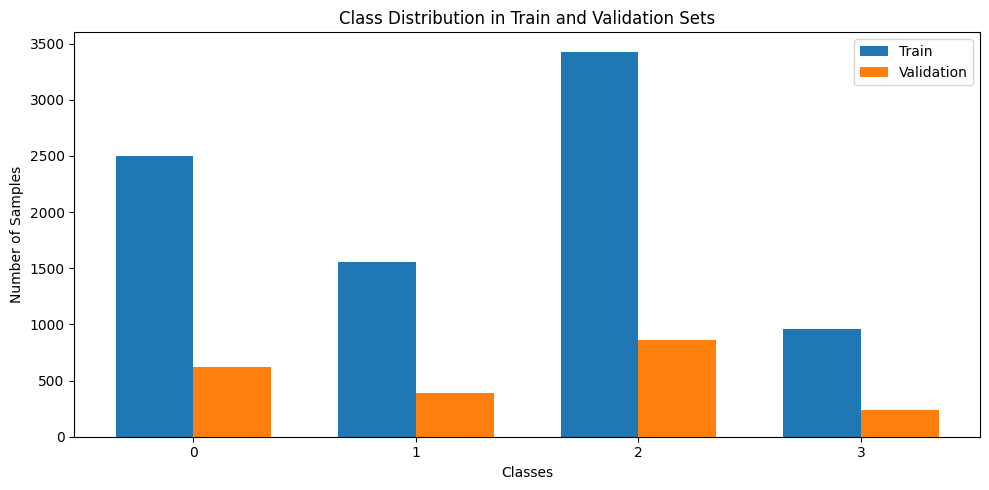

In [28]:
# Visualize class distribution
print("\nVisualizing class distribution...")
# This assumes you have a 'plot_class_distribution' function available from your visualization.py file
plot_class_distribution(train_dataset, val_dataset)

In [29]:
# Save the final datasets
print("\nSaving final datasets...")

# Create processed directory
processed_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)

# Save datasets using the custom function
save_large_dataset(train_dataset, processed_dir, "train")
save_large_dataset(val_dataset, processed_dir, "val")

print("Final datasets saved successfully to the 'processed' directory.")


Saving final datasets...

Saving train...
Saving corrected tensor with 8448 samples...
Saving edge tensor with 8448 samples...
Saving threshold tensors...
Saving threshold tensor 'low' with 8448 samples...
Saving threshold tensor 'medium' with 8448 samples...
Saving threshold tensor 'high' with 8448 samples...
Saving threshold tensor 'very_high' with 8448 samples...
Saving labels and metadata with 8448 samples...
train saved successfully!

Saving val...
Saving corrected tensor with 2112 samples...
Saving edge tensor with 2112 samples...
Saving threshold tensors...
Saving threshold tensor 'low' with 2112 samples...
Saving threshold tensor 'medium' with 2112 samples...
Saving threshold tensor 'high' with 2112 samples...
Saving threshold tensor 'very_high' with 2112 samples...
Saving labels and metadata with 2112 samples...
val saved successfully!
Final datasets saved successfully to the 'processed' directory.


In [30]:
# Clean up memory
print("\nCleaning up memory...")
del preprocessed_dataset, X_permuted, y_permuted, full_shuffled_dataset, train_dataset, val_dataset
gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Memory cleaned.")


Cleaning up memory...
Memory cleaned.


In [9]:
# Load the saved train and validation datasets
print("Loading saved datasets...")

# Define paths
train_path = os.path.join(project_root, 'data', 'processed', 'train')
val_path = os.path.join(project_root, 'data', 'processed', 'val')

def load_saved_dataset(dataset_path, name):
    """Load dataset components that were saved separately."""
    print(f"\nLoading {name} dataset...")
    
    # Load tensors
    tensor_dir = os.path.join(dataset_path, 'tensors')
    threshold_dir = os.path.join(tensor_dir, 'threshold')
    
    # Load corrected tensor
    corrected_tensor = torch.load(os.path.join(tensor_dir, 'corrected.pt'))
    
    # Load edge tensor  
    edge_tensor = torch.load(os.path.join(tensor_dir, 'edge.pt'))
    
    # Load threshold tensors
    threshold_tensors = {}
    for filename in os.listdir(threshold_dir):
        level = filename.replace('.pt', '')
        threshold_tensors[level] = torch.load(os.path.join(threshold_dir, filename))
    
    # Load metadata (contains labels and indices)
    metadata = torch.load(os.path.join(dataset_path, 'metadata.pt'))
    
    print(f"{name} dataset loaded with {len(metadata['labels'])} samples")
    
    return {
        'corrected_tensor': corrected_tensor,
        'edge_tensor': edge_tensor,
        'threshold_tensors': threshold_tensors,
        'labels': metadata['labels'],
        'indices': metadata['indices']
    }

# Load both datasets
train_data = load_saved_dataset(train_path, 'train')
val_data = load_saved_dataset(val_path, 'validation')

# Get the label mapping from the original preprocessed data
# (it's the same for both datasets)
cotopaxi_preprocessed_path = os.path.join(project_root, 'data', 'processed', 'cotopaxi_preprocessed.pt')
temp_data = torch.load(cotopaxi_preprocessed_path, weights_only=False)
label_mapping = temp_data['labels']['label_mapping']
del temp_data  # Clean up

print("\n=== Dataset Summary ===")
print(f"Train samples: {len(train_data['labels'])}")
print(f"Validation samples: {len(val_data['labels'])}")
print(f"Label mapping: {label_mapping}")

Loading saved datasets...

Loading train dataset...


C:\Users\Francisco\AppData\Local\Temp\ipykernel_4916\3696334051.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  corrected_tensor = torch.load(os.path.join(tensor_dir, '

train dataset loaded with 8448 samples

Loading validation dataset...
validation dataset loaded with 2112 samples

=== Dataset Summary ===
Train samples: 8448
Validation samples: 2112
Label mapping: {'Despejado': 0, 'Nublado': 1, 'Emisiones': 2, 'Flujo': 3}



Creating labeled class distribution plot...


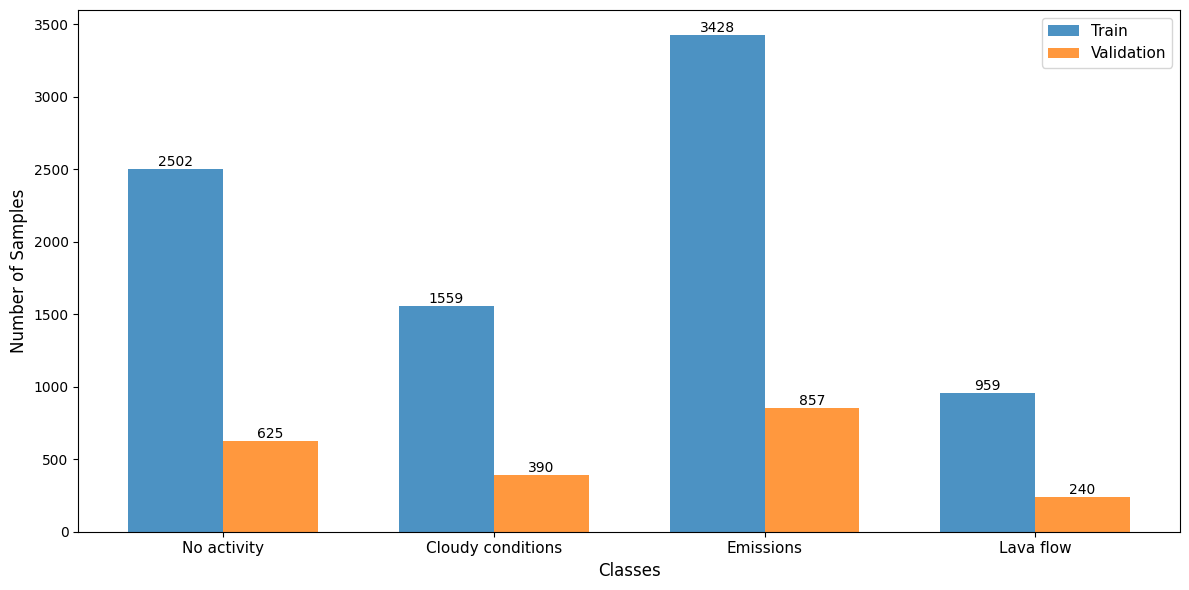


=== Class Distribution Statistics ===

Total samples: 10560
Train samples: 8448 (80.0%)
Validation samples: 2112 (20.0%)

--- Per-Class Distribution ---

No activity:
  Train: 2502 ( 29.6% of train set)
  Val:    625 ( 29.6% of val set)
  Total: 3127 ( 29.6% of all data)

Cloudy conditions:
  Train: 1559 ( 18.5% of train set)
  Val:    390 ( 18.5% of val set)
  Total: 1949 ( 18.5% of all data)

Emissions:
  Train: 3428 ( 40.6% of train set)
  Val:    857 ( 40.6% of val set)
  Total: 4285 ( 40.6% of all data)

Lava flow:
  Train:  959 ( 11.4% of train set)
  Val:    240 ( 11.4% of val set)
  Total: 1199 ( 11.4% of all data)


In [14]:
# Create labeled class distribution plot
print("\nCreating labeled class distribution plot...")

# Get labels from loaded datasets
train_labels = train_data['labels'].numpy()
val_labels = val_data['labels'].numpy()

# Create inverse mapping (numeric -> name)
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Get unique labels and their counts
unique_labels = sorted(set(train_labels))
train_counts = [np.sum(train_labels == label) for label in unique_labels]
val_counts = [np.sum(val_labels == label) for label in unique_labels]

# Create label names for x-axis
label_names = [inv_label_mapping[label] for label in unique_labels]

# Create English translations for better readability
label_translations = {
    'Despejado': 'No activity',
    'Emisiones': 'Emissions',
    'Nublado': 'Cloudy conditions',
    'Flujo': 'Lava flow'
}
label_names_english = [label_translations.get(name, name) for name in label_names]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(unique_labels))
width = 0.35

bars1 = ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)#, color='light_blue')
bars2 = ax.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8)#, color='orange')

# Customize the plot
ax.set_xlabel('Classes', fontsize=12, fontweight='regular')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='regular')
#ax.set_title('Class Distribution in Train and Validation Sets', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(label_names_english, fontsize=11)
ax.legend(fontsize=11)
#ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Class Distribution Statistics ===")
print(f"\nTotal samples: {len(train_labels) + len(val_labels)}")
print(f"Train samples: {len(train_labels)} ({len(train_labels)/(len(train_labels) + len(val_labels))*100:.1f}%)")
print(f"Validation samples: {len(val_labels)} ({len(val_labels)/(len(train_labels) + len(val_labels))*100:.1f}%)")

print("\n--- Per-Class Distribution ---")
for i, label_name in enumerate(label_names_english):
    total = train_counts[i] + val_counts[i]
    print(f"\n{label_name}:")
    print(f"  Train: {train_counts[i]:4d} ({train_counts[i]/len(train_labels)*100:5.1f}% of train set)")
    print(f"  Val:   {val_counts[i]:4d} ({val_counts[i]/len(val_labels)*100:5.1f}% of val set)")
    print(f"  Total: {total:4d} ({total/(len(train_labels) + len(val_labels))*100:5.1f}% of all data)")